# Imports


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.is_available()

True

In [2]:
import csv
PATH = 'data/'
CSV = PATH+'training.csv'

In [4]:
rows=[]
bbs = []
name = []
with open(CSV, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        coo = str(row[3]) + ' ' + str(row[1]) + ' ' + str(row[4]) + ' ' + str(row[2])
        if coo[0]!='y':
            bbs.append(coo)
            name.append(row[0])
print (bbs[:4])
print (name[:4])

['143 115 325 495', '61 23 409 457', '13 37 470 601', '162 27 385 602']
['JPEG_20160706_121146_1000145715002.png', 'JPEG_20161119_174038_1000690577600.png', '147444927651111470309333776-Roadster-Men-Casual-Shoes-3041470309333487-1.png', '147772332675720161028_161611.png']


In [5]:
BB_CSV = Path('bb.csv')
df = pd.DataFrame({'fn': name, 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 'JPEG_20160706_121146_1000145715002.png,143 115 325 495\n',
 'JPEG_20161119_174038_1000690577600.png,61 23 409 457\n',
 '147444927651111470309333776-Roadster-Men-Casual-Shoes-3041470309333487-1.png,13 37 470 601\n',
 '147772332675720161028_161611.png,162 27 385 602\n']

# Images

In [43]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
def bb_hw(a): 
    len(a)
    return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [44]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

# Model and train

In [46]:
f_model=resnet34
sz=224
bs=64

In [45]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)

In [8]:
PATH = Path('')
JPEGS = 'data/images'

In [11]:
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, test_name = 'test' ,tfms=tfms, bs=bs, continuous=True)

In [54]:
??ImageClassifierData.from_csv

In [12]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

 69%|██████▊   | 120/175 [02:14<00:26,  2.07it/s, loss=158] 

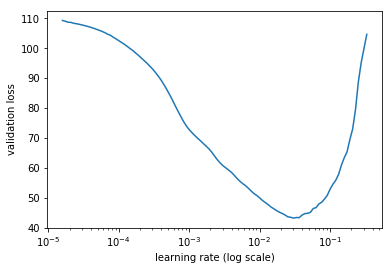

In [42]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [43]:
lr = 9e-3
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      16.107961  10.547426 
    1      12.879496  10.773041                             
    2      8.806656   8.851675                              


[8.851675126211983]

In [44]:
learn.save('reg4')
learn.load('reg4')

In [78]:
imgpath = 'data/images/JPEG_20161123_184340_1000982358317.png'
trn_tfms, val_tfms = tfms_from_model(f_model, sz)
im = val_tfms(open_image(imgpath)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])

In [80]:
preds=[169,112,337,483]

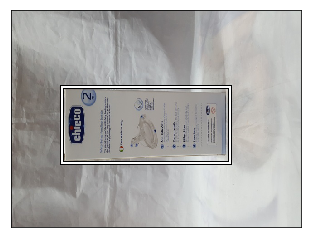

In [81]:
im = open_image(imgpath)
ax = show_img(im)
b = bb_hw(preds)
draw_rect(ax, b)

 66%|██████▌   | 115/175 [03:16<01:36,  1.60s/it, loss=16.1] 

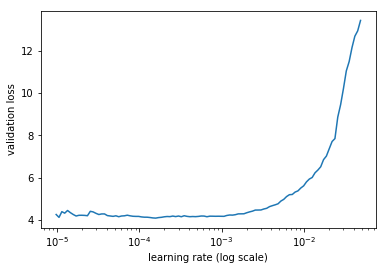

In [16]:
lr = 9e-3
lrs = np.array([lr/100,lr/10,lr])
learn.freeze_to(-2)
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [54]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      9.213698   5.924201  
    1      8.433819   6.917633                              
    2      4.761753   4.263337                              


[4.263337079456874]

In [55]:
learn.save('reg5')

In [56]:
learn.freeze_to(-3)

In [17]:
learn.load('reg5')

In [18]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                              
    0      7.481836   5.033866  
    1      4.316168   4.189343                              


[4.189342990602766]

In [19]:
learn.save('reg6')
learn.load('reg6')

In [30]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [32]:
type(x)
x.shape

torch.Size([64, 3, 224, 224])

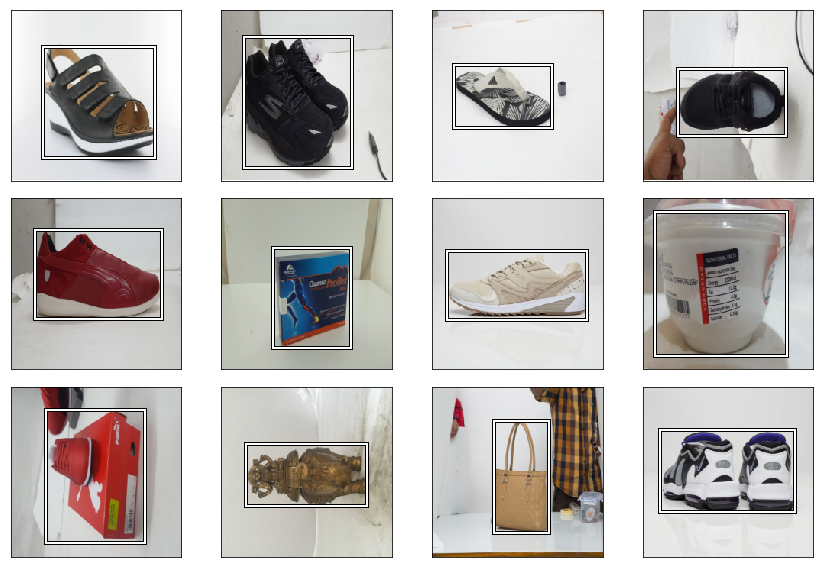

In [64]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

# Make test image

In [56]:
TEST_CSV = 'data/test.csv'
test_df = pd.read_csv(TEST_CSV)
FOLDER_TEST = 'data/test/'

In [57]:
for im in test_df.image_name:
    source = f'data/images/{im}'
    desitnation = f'{FOLDER_TEST}{im}'
    !cp {source} {desitnation}

# Test

In [59]:
??ImageClassifierData.from_csv

In [96]:
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, test_name = 'data/test' ,tfms=tfms, bs=bs, continuous=True)

In [82]:
x,y = next(iter(md.test_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [127]:
answer = np.ones((1,4))

In [130]:
for x,y in md.test_dl:
    learn.model.eval()
    preds = to_np(learn.model(VV(x)))
    answer = np.append(answer, preds, axis = 0)

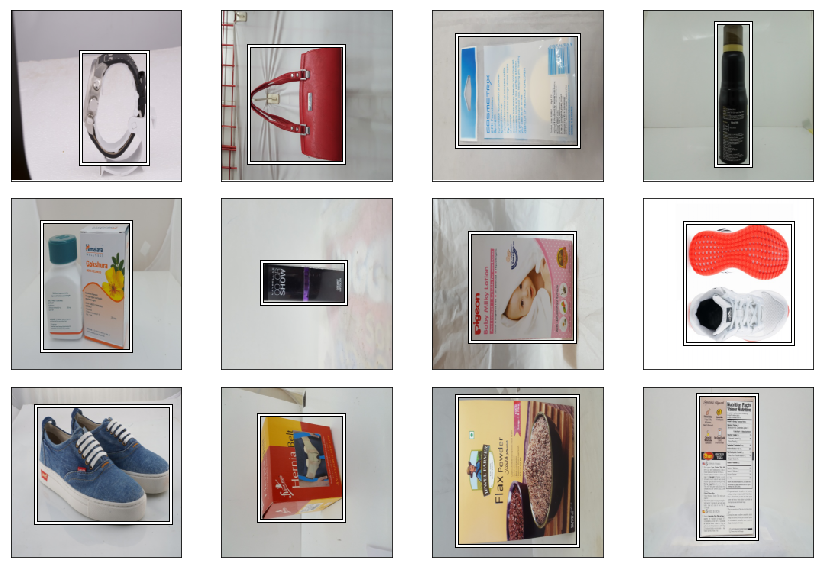

In [83]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

In [159]:
kek = bb_hw(preds[1])
??draw_rect
preds[1]

array([ 62.99148,  45.22914, 158.38158, 200.87105], dtype=float32)

In [158]:
kek[:2]

array([45.22914, 62.99148])

In [117]:
preds.shape

(64, 4)

In [125]:
np.array([[1,2,3,4]]).T.shape

(4, 1)

In [148]:
answer_df = pd.DataFrame(answer[1:])

In [149]:
answer_df['filename'] = md.test_ds.fnames

# Create answer

In [151]:
TESTING_CSV = 'data/test.csv'
testdf = pd.read_csv(TESTING_CSV)

In [168]:
answer_df = copya.copy()
answer_df.head()

,0,1,2,3,filename
0,54.877441,91.929382,201.120804,178.819992,data/test/1480335044628_R2A3720.png
1,46.693600,35.856537,198.933609,160.069168,data/test/JPEG_20160525_134615_100073334694.png
2,32.832169,31.877768,178.623459,191.989380,data/test/JPEG_20161126_171706_1000964416084.png
3,16.643345,95.550148,204.100769,140.498215,data/test/JPEG_20160711_112948_1000240078533.png
4,31.070852,40.640881,199.037476,155.941330,data/test/JPEG_20160622_145634_100096429359.png


In [184]:
answer_df['filename'] = answer_df['filename'].apply(lambda x: x.split('/')[-1])

In [193]:
answer_df[answer_df['filename'] == '1480335044628_R2A3720.png']

,0,1,2,3,filename
0,54.877441,91.929382,201.120804,178.819992,1480335044628_R2A3720.png


In [201]:
for i, row in testdf.iterrows():
    answer_row = answer_df[answer_df['filename'] == row['image_name']]
#     x1, x2, y1, y2 = answer_row[1], answer_row[3], answer_row[0], answer_row[2]
    testdf.at[i,'x1'], testdf.at[i,'x2'], testdf.at[i,'y1'], testdf.at[i,'y2'] = answer_row[1], answer_row[3], answer_row[0], answer_row[2]

In [200]:
testdf

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN
5,147444974116511473239803010-Mast--Harbour-Men-...,NaN,NaN,NaN,NaN
6,JPEG_20160622_110649_1000527459853.png,NaN,NaN,NaN,NaN
7,JPEG_20160823_120737_1000784898268.png,NaN,NaN,NaN,NaN
8,1480965956645IMG_3094.png,NaN,NaN,NaN,NaN
9,14732348976417a565e40d545452688130062b267a2d2.png,NaN,NaN,NaN,NaN


In [202]:
testdf.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,81.916466,154.987045,40.716919,188.629791
1,1473231475010DeeplearnS11276.png,26.953066,197.117767,66.211769,163.248093
2,JPEG_20161205_135307_1000155917326.png,50.880569,170.428833,25.556602,193.423569
3,JPEG_20160711_123440_1000518778437.png,76.443871,156.878754,45.867252,187.170044
4,JPEG_20160803_115329_100034020722.png,43.406708,172.716293,20.672409,202.381744


In [203]:
testdf.to_csv('answer_v1.csv')